In [1]:
!pip install --upgrade pip
!pip install umap-learn
!pip install plotly
!pip install scikit-learn
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 5.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 6.4 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82814 sha256=323c80e8586dbd66c706e9de8fb3288a609031ebf0df33b9dc68be9628f58fdf
  Stored in directory: /root/.cache/pip/wheels/de/b2/e6/f3710dd75722ad40e856825ebdb090021a774e59f07d39bfc6
  Created wheel for pynndescent: fil

In [2]:
import os
import random
from pathlib import Path
import time

from numpy import savetxt, loadtxt

from torchvision import transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import kaleido
import umap
import plotly
import plotly.express as px
import plotly.io as plt_io
import plotly.graph_objects as go


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import vision_transformer as vits
from CustomDataset.ShipDataset import ShipDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [3]:
os.chdir("../")
!pwd

/home/dh/Workspace/dino


In [4]:
!pwd

/home/dh/Workspace/dino


In [5]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=4):
        super(LinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [6]:
def load_model(model_savename, model_type='vit_small'):
    patch_size = 16
    size = (1600, 1600)
    if model_type == 'vit_tiny':
        model = vits.__dict__['vit_tiny'](patch_size=patch_size, num_classes=4)
    elif model_type == 'vit_small':
        model = vits.__dict__['vit_small'](patch_size=patch_size, num_classes=4)
    elif model_type == 'vit_base':
        model = vits.__dict__['vit_base'](patch_size=patch_size, num_classes=4)    
    elif model_type == 'resnet50':
        print('resnet does not have attention maps...')
        return
        #model = resnet50(pretrained=False)
    
    checkpoint = "teacher"
    pretrained_weights = f"{model_savename}"

    if os.path.isfile(pretrained_weights):
        state_dict = torch.load(pretrained_weights, map_location="cpu")
        if checkpoint is not None and checkpoint in state_dict:
            #print(f"Take key {checkpoint} in provided checkpoint dict")
            state_dict = state_dict[checkpoint]
        # remove `module.` prefix
        state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
        # remove `backbone.` prefix induced by multicrop wrapper
        state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

        #print(state_dict.keys())

        msg = model.load_state_dict(state_dict, strict=False)
        #print(f"Loaded {model_savename}")
        #print('Pretrained weights found at {} and loaded with msg: {}'.format('checkpoint.pth', msg))
        
    else:
        print("Failed to load")
        return None, False
        
    for p in model.parameters():
        p.requires_grad = False
        
    model.eval()
    model.to(device)
    
    return model, True

def generate_embeddings(model, x):
    '''
    Generate embeddings for an input batched tensor

    Args:
        x (torch.Tensor) : A batched pytorch tensor

    Returns:
        (torch.Tensor): The output of self.model against x
    '''
    return(model(x))

def plot_2d(component1, component2, save_location, graph_type, show_fig=True, save_img=False):
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode = 'markers',
        marker = dict(
            size = 10,
            color = labels, # Set color equal to a variable
            colorscale = 'Rainbow', # Plotly colorscale
            showscale = True,
            opacity = 0.2,
            line_width = 1,
        )
    ))
    
    fig.update_layout(margin=dict(l=100, r=100, b=100, t=100), width=1000, height=800)
    fig.layout.template = 'plotly_dark'
    
    if show_fig:
        fig.show()
    
    if save_img:
        try:
            fig.write_image(f"{save_location}/{graph_type}.png")
            print(f"Image saved as {save_location}/{graph_type}.png")
        except:
            print("Something went wrong...")
            print(f"Failed to save as {save_location}/{graph_type}.png")
        
def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
            x = component1,
            y = component2,
            z = component3,
            mode = 'markers',
            marker = dict(
                size = 10,
                color = labels, # Set color equal to a variable
                colorscale = 'Rainbow', # Plotly colorscale
                opacity = 1,
                line_width = 1,
            )
        )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1000,height=800)
    fig.layout.template = 'plotly_dark'

    fig.show()
        
from sklearn.preprocessing import StandardScaler
    
def load_n_standardize_features(embedding_path):
    features = loadtxt(f"{embedding_path}/features.csv", delimiter=',')
    features = StandardScaler().fit_transform(features)
    
    return features

def save_features(embedding_path, features, labels, paths):
    if not os.path.exists(embedding_path):
        os.mkdir(embedding_path)
        
    savetxt(f"{embedding_path}/features.csv", features, delimiter=',')
    savetxt(f"{embedding_path}/labels.csv", labels, delimiter=",", fmt="%d")
    savetxt(f"{embedding_path}/paths.csv", paths, delimiter=",", fmt="%s")

def load_features(model_name):
    features = loadtxt(f"{embedding_path}/features.csv", delimiter=",")
    labels = loadtxt(f"{embedding_path}/labels.csv", delimiter=",", dtype="int")
    paths = loadtxt(f"{embedding_path}/paths.csv", delimiter=",", dtype="str")
    
    return features, labels, paths

In [31]:
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn, optim

import timm
from timm.loss import LabelSmoothingCrossEntropy # Better than nn.CrossEntropyLoss

def get_data_loader(data_dir, batch_size, ds_type):
    if ds_type == "train":
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random'),
        ])
        img_dataset = datasets.ImageFolder(os.path.join(data_dir, ds_type), transform=transform)
    
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        img_dataset = datasets.ImageFolder(os.path.join(data_dir, ds_type), transform=transform)
        
    data_loader = DataLoader(img_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    
    return data_loader, len(img_dataset)
    
        
    

In [58]:
ARCH_TYPE = "vit_base"
PROBLEM = "14to4"
CKP_FOLDER = f"{ARCH_TYPE}_{PROBLEM}"
CKP_NAME = "checkpoint0500.pth"

def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir + "/train")
    return all_data.classes    
classes = get_classes(DATA_DIR)

model_savename = f"checkpoint.pth.tar"
model_dict = torch.load(model_savename)

# criterion = LabelSmoothingCrossEntropy()
# criterion = criterion.to(device)
optimizer = model_dict['optimizer']

# BUG : Load DINO HEAD and replace LinearClassifier

model = LinearClassifier(3072)

model_dict['state_dict']['linear.weight'] = model_dict['state_dict']['module.linear.weight']
del model_dict['state_dict']['module.linear.weight']
model_dict['state_dict']['linear.bias'] = model_dict['state_dict']['module.linear.bias']
del model_dict['state_dict']['module.linear.bias']

model.load_state_dict(model_dict['state_dict'])


# lr scheduler
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

<All keys matched successfully>

In [61]:
model

LinearClassifier(
  (linear): Linear(in_features=3072, out_features=4, bias=True)
)

In [59]:
DATA_DIR = "../data/ship_500train_500val_200test"
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

test_loader, test_size = get_data_loader(DATA_DIR, BATCH_SIZE, "test")
print(f"Test Set has {test_size} data")

Test Set has 800 data


In [60]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.to(device)
model.eval()

for data, target in tqdm(test_loader, leave=True):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == BATCH_SIZE:
        for i in range(BATCH_SIZE):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
test_loss = test_loss / test_size
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print(f"Test Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))

print(f"Test Accuracy of {100*np.sum(class_correct)/np.sum(class_total):.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})")

  0%|                                                                                                                                               | 0/7 [00:02<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x150528 and 3072x4)

In [38]:
# Load Dataset and DataLoader

BATCH_SIZE = 128

def stack(tensor, times=3):
  return(torch.cat([tensor]*times, dim=0))

tfs = transforms.Compose([transforms.Resize((221,221)), 
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485], std=[0.229])])

DATASET_PATH = "../data"
ship_data = ShipDataset(root=DATASET_PATH, ds_type="full", train_ratio=1, method="self-supervised",
    transform=tfs)

data_loader = torch.utils.data.DataLoader(ship_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

  0%|          | 0/4 [00:00<?, ?class/s]

  0%|          | 0/5482 [00:00<?, ?images/s]

  0%|          | 0/5310 [00:00<?, ?images/s]

  0%|          | 0/6397 [00:00<?, ?images/s]

  0%|          | 0/7361 [00:00<?, ?images/s]

full loaded


In [7]:
ARCH_TYPE = "vit_base"
PROBLEM = "14to4"
CKP_FOLDER = f"{ARCH_TYPE}_{PROBLEM}"
CKP_NAME = "checkpoint0500.pth"

model_name = CKP_NAME.replace(".pth", "")

if ARCH_TYPE == "vit_small":
    eval_image = f"vs_{model_name}"
elif ARCH_TYPE == "vit_base":
    eval_image = f"vb_{model_name}"
else:
    eval_image = model_name
    

model_savename = f"checkpoints/{CKP_FOLDER}/{CKP_NAME}"
model, load_status = load_model(model_savename, ARCH_TYPE)

embedding_path = f"eval_maps/embeddings/{ARCH_TYPE}/{PROBLEM}/{model_name}"
print(embedding_path)
# Check if embeddings is already saved
if not os.path.exists(embedding_path):
    print("Generating feature set")
    if ARCH_TYPE == "vit_small":
        features = np.zeros((0, 384))
    elif ARCH_TYPE == "vit_base":
        features = np.zeros((0, 768))
        
    labels = np.zeros((0))
    paths = np.zeros((0))
    for batch_imgs, batch_labels, batch_paths in tqdm(data_loader, unit="batch"):
        labels = np.hstack((labels, batch_labels.numpy()))
        paths = np.hstack((paths, np.asarray(batch_paths)))
        embs = generate_embeddings(model, batch_imgs.to(device))
        features = np.vstack((features, embs.cpu().detach().numpy()))
        
    save_features(embedding_path, features, labels, paths)
        
else:
    print("Loading feature set from csv")
    features, labels, paths = load_features(embedding_path)
    
if features is not None:
    print("Features loaded")

eval_maps/embeddings/vit_small/14to4/checkpoint0500
Generating feature set


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [03:26<00:00,  1.08s/batch]


Features loaded


In [ ]:
CLASSES = ['ContainerShip', 'Cruise', 'Tanker', 'Warship']

In [11]:
# UMAP (Uniform Manifold Approximation and Projection)
features = load_n_standardize_features(embedding_path)

start = time.time()
reducer = umap.UMAP(random_state=42, n_components=2)
embedding = reducer.fit_transform(features)
print(f"Duration: {time.time() - start} seconds")

Duration: 21.89775514602661 seconds


In [12]:
!pwd

/home/dh/Workspace/dino


In [13]:
save_location = f"eval_maps/images/{ARCH_TYPE}/{PROBLEM}/{model_name}"
print(save_location)
plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1], save_location, "UMAP", False, True)

eval_maps/images/vit_small/14to4/checkpoint0500
Image saved as eval_maps/images/vit_small/14to4/checkpoint0500/UMAP.png


In [14]:
assert len(reducer.embedding_) == len(labels), "Labels len does not equal embedding len"

print(type(reducer.embedding_))
print(reducer.embedding_.shape)
split_class = {}

for class_idx in range(4):
    split_class[class_idx] = {}
    split_class[class_idx]["embeddings"] = [reducer.embedding_[idx] 
                                            for idx, val 
                                            in np.ndenumerate(labels) 
                                            if val == class_idx]
    
    split_class[class_idx]["label"] = [idx 
                                       for idx, val 
                                       in np.ndenumerate(labels) 
                                       if val == class_idx]

<class 'numpy.ndarray'>
(24550, 2)


In [15]:
total_imgs = 0
for class_idx in range(4):
    print(f"{CLASSES[class_idx]}: {split_class[class_idx]['label'][0:5]}")
    total_imgs += len(split_class[class_idx]['label'])
    
assert total_imgs == len(labels), "Total imgs dont match"    
# print(labels[0:50])

# for i in range(10):
#     class_name = paths[i].split('/')[3]
#     print(class_name)

ContainerShip: [(4,), (25,), (27,), (29,), (37,)]
Cruise: [(2,), (6,), (24,), (35,), (40,)]
Tanker: [(3,), (7,), (11,), (14,), (18,)]
Warship: [(0,), (1,), (5,), (8,), (9,)]


In [16]:
CLASSES = ['ContainerShip', 'Cruise', 'Tanker', 'Warship']
class_avg = {}

# Finding Centroids of each class
centroids_x, centroids_y = [], []
for class_idx in range(4):
    split_class[class_idx]["embeddings"] = np.array(split_class[class_idx]["embeddings"])
    
    class_avg[class_idx] = np.average(split_class[class_idx]["embeddings"], axis=0)
    
    centroids_x.append(class_avg[class_idx][0])
    centroids_y.append(class_avg[class_idx][1])

    print(f"Centroid for {CLASSES[class_idx]} is ({class_avg[class_idx][0]}, {class_avg[class_idx][1]})")

Centroid for ContainerShip is (0.28899243474006653, 10.070520401000977)
Centroid for Cruise is (0.9187750220298767, 0.764332115650177)
Centroid for Tanker is (-0.7229357957839966, 8.65658187866211)
Centroid for Warship is (-0.6955985426902771, 3.8262641429901123)


In [17]:
# Find average distance and std
class_dist = {}
class_outliers = {}

for class_idx in range(4):
    class_dist[class_idx] = []
    for point in split_class[class_idx]["embeddings"]:
        class_dist[class_idx].append(np.linalg.norm(point - np.array(class_avg[class_idx])))

    np_distances = np.array(class_dist[class_idx])

    average_dist = np.average(np_distances)
    std_dist = np.std(np_distances)

    print(f"Average distance for {CLASSES[class_idx]} is {average_dist}")
    print(f"Std distance for {CLASSES[class_idx]} is {std_dist}")

    # Isolate those above 2 SD away?
    class_outliers[class_idx] = [split_class[class_idx]["label"][idx] for idx, val in enumerate(class_dist[class_idx]) 
                if val > average_dist + 3 * std_dist or val < average_dist - 3 * std_dist]

    print(f"There are {len(class_dist[class_idx])} data in {CLASSES[class_idx]}")
    print(f"There are {len(class_outliers[class_idx])} outliers in {CLASSES[class_idx]}")
    print(f"{round(len(class_outliers[class_idx]) / len(class_dist[class_idx]), 2)}% of data are outliers")
    print()

Average distance for ContainerShip is 2.1599745750427246
Std distance for ContainerShip is 1.5916047096252441
There are 5482 data in ContainerShip
There are 190 outliers in ContainerShip
0.03% of data are outliers

Average distance for Cruise is 1.9006409645080566
Std distance for Cruise is 1.6622346639633179
There are 5310 data in Cruise
There are 267 outliers in Cruise
0.05% of data are outliers

Average distance for Tanker is 1.851587176322937
Std distance for Tanker is 1.2912237644195557
There are 6397 data in Tanker
There are 197 outliers in Tanker
0.03% of data are outliers

Average distance for Warship is 1.6373512744903564
Std distance for Warship is 0.9972292184829712
There are 7361 data in Warship
There are 128 outliers in Warship
0.02% of data are outliers



In [18]:
fig_data = [
   go.Scatter(
        x = reducer.embedding_[:, 0],
        y = reducer.embedding_[:, 1],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = labels, # Set color equal to a variable
            colorscale = 'Rainbow', # Plotly colorscale
            showscale = True,
            opacity = 0.2,
            line_width = 1,
        )
    ),
    
    go.Scatter(
        x = centroids_x,
        y = centroids_y,
        mode = 'markers',
        marker = dict(
            size = 15,
            color = [0, 1, 2, 3],
            colorscale = 'Rainbow',
            showscale = True,
            opacity = 1,
            line_width = 1,
        )
    ),
]

fig = go.Figure(data=fig_data)
    
fig.update_layout(margin=dict(l=100, r=100, b=100, t=100), width=1000, height=800)
fig.layout.template = 'plotly_dark'
fig.show()

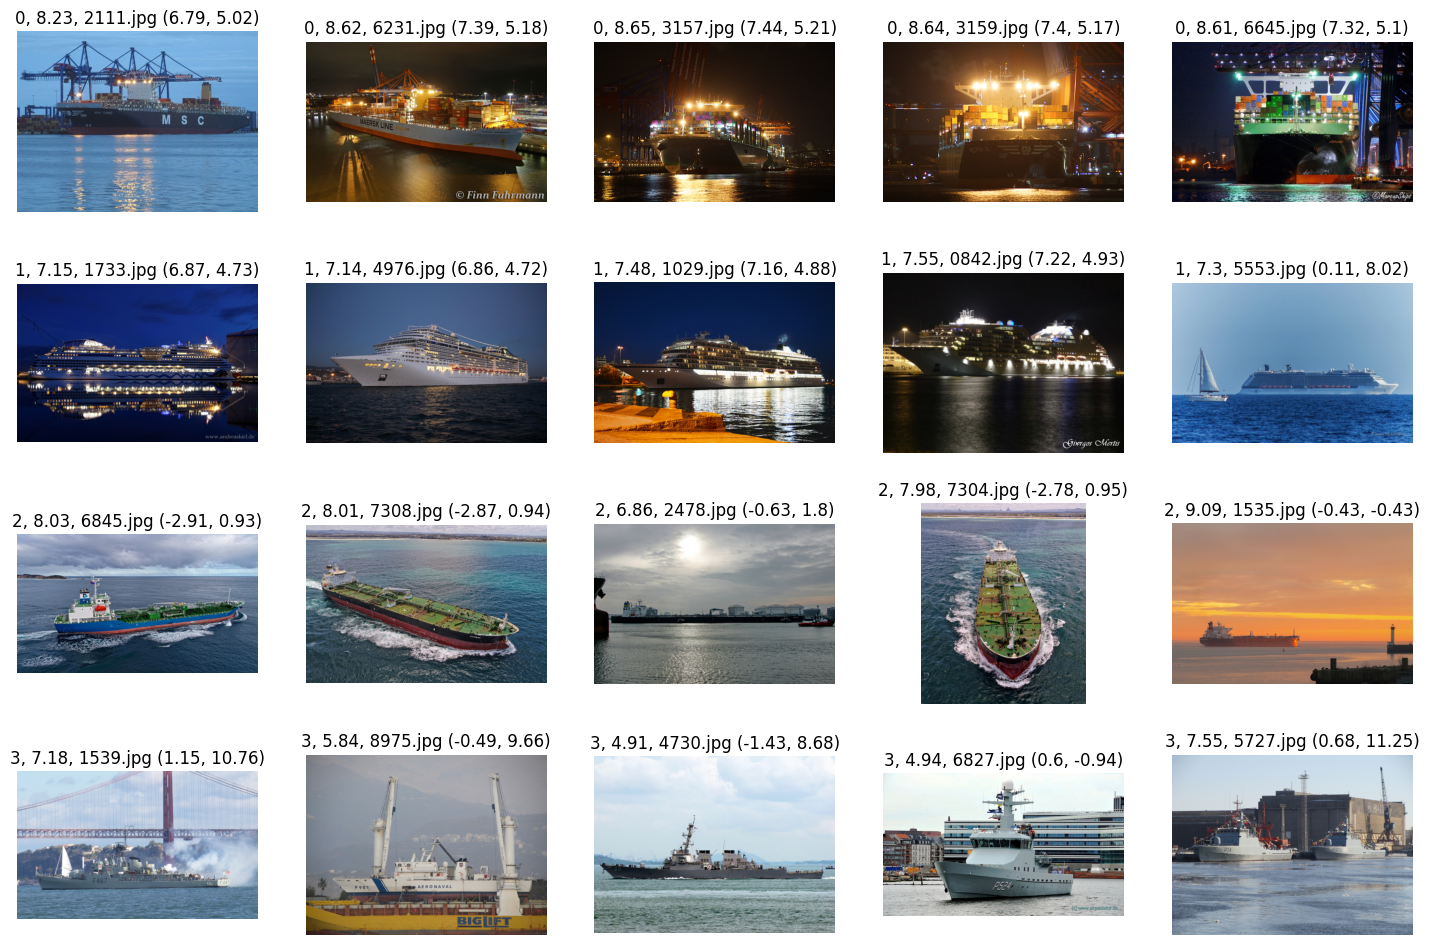

In [22]:
# Display correct and incorrect samples
RANDOM = True

fig, ax = plt.subplots(len(CLASSES), 5, figsize=(18,12))

for class_idx in range(4):
    samples = {}
    samples['paths'] = []
    samples['embed'] = []
    if RANDOM:
        # Take 5 random samples
        sample_idx = random.sample(class_outliers[class_idx], 5)
    else:
        # Take first 5 samples
        sample_idx = class_outliers[class_idx][:5]
    
    for idx in sample_idx:
        # Add embedding and path
        #print(paths[idx])
        #print(reducer.embedding_[idx])
        samples['paths'].append(paths[idx])
        samples['embed'].append(reducer.embedding_[idx])
        
    # Show wrong samples
    for i in range(5):
        # TODO To refine, show green if closest centroid is still correct class
        
        dist = np.linalg.norm(samples['embed'][i] - np.array(class_avg[class_idx]))
        with open(samples['paths'][i], 'rb') as f:
            image = Image.open(f)
            ax[class_idx][i].imshow(image, cmap='gray')
            ax[class_idx][i].axis("off")
            ax[class_idx][i].set_title(f"{class_idx}, {round(float(dist),2)}, {samples['paths'][i].split('/')[4][-8:]} ({round(float(samples['embed'][i][0]),2)}, {round(float(samples['embed'][i][1]), 2)})")
fig.show()

In [ ]:
Image.open('../data/sub_ship_spotting_single_2/Tanker/2427797.jpg')

In [8]:
# # PCA (Principal Component Analysis)
# features = load_n_standardize_features(embedding_path)
# start = time.time()


# pca = PCA(n_components = 3)
# principalComponents = pca.fit_transform(features)
# print(f"Duration: {time.time() - start} seconds")
# principal = pd.DataFrame(data = principalComponents,
#                         columns = ['principal component 1',
#                                    'principal component 2',
#                                    'principal component 3'])

In [9]:
# plot_2d(principalComponents[:, 0], principalComponents[:, -1], model_name, "PCA", True, False)

In [ ]:
# # t-SNE (T-distributed Stochastic Neighbor Embedding)
# features = load_n_standardize_features(embedding_path)

# start = time.time()
# pca_50 = PCA(n_components=50)
# pca_result_50 = pca_50.fit_transform(features)
# tsne = TSNE(random_state=42, n_components=3, verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_50)
# print(f"Duration: {time.time() - start} seconds")


In [ ]:
# plot_2d(tsne[:, 0],tsne[:, 1], "t-SNE", model_name, False, True)

In [ ]:
# # LDA (Linear Discrimination Analysis)
# features = load_n_standardize_features(embedding_path)

# start = time.time()
# X_LDA = LDA(n_components=3).fit_transform(features, labels)
# print(f"Duration {time.time() - start} seconds")

In [ ]:
# plot_2d(X_LDA[:, 0],X_LDA[:, 1], model_name, "LDA", True, False)

In [ ]:
# models = [f.name for f in os.scandir("models") if f.is_file()]
# models.sort()

# models

# models = ['checkpoint0500.pth']
# models

In [ ]:
# models = [f.name for f in os.scandir("checkpoints/vit_base_14to4") if f.is_file() and f.name.endswith('.pth')]
# models.sort()
# models

# models = ['checkpoint0050.pth']
# MODELS_FOLDER = 'checkpoints/vit_base_14to4'

In [ ]:
# # import warnings filter
# from warnings import simplefilter
# # ignore all future warnings
# simplefilter(action='ignore', category=FutureWarning)


# # models = [f.name for f in os.scandir("models") if f.is_file()]
# # models.sort()


# for model_name in tqdm(models, leave=False):
#     torch.cuda.empty_cache()
#     model_name = model_name.replace(".pth", "")
#     model_savename = f"vs_{model_name}"
#     print(f"Generating eval maps for {model_name}")
#     model, load_status = load_model(f"{MODELS_FOLDER}/{model_name}.pth", 'vit_base')
    
#     if load_status is not True:
#         print(f"Failed to load {model_name}")
#         pass
    
#     else:
#         if not os.path.exists(f"eval_maps/embeddings/{model_savename}"):
#             print("Generating feature set")
#             features = np.zeros((0, 768))
#             labels = np.zeros((0))
#             for batch_imgs, batch_labels in tqdm(data_loader, unit="batch", leave=True, position=0):
#                 labels = np.hstack((labels, batch_labels.numpy()))
#                 embs = generate_embeddings(model, batch_imgs.to(device))
#                 features = np.vstack((features, embs.cpu().detach().numpy()))
#             save_features(model_name, features, labels)
#         else:
#             print("Loading feature set from csv")
#             features, labels = load_features(model_savename)

#         # PCA (Principal Component Analysis)
#         features = load_n_standardize_features(model_name)
#         start = time.time()
        
#         pca = PCA(n_components = 3)
#         principalComponents = pca.fit_transform(features)
#         print(f"Duration (PCA): {time.time() - start} seconds")
#         principal = pd.DataFrame(data = principalComponents,
#                                 columns = ['principal component 1',
#                                            'principal component 2',
#                                            'principal component 3'])
        
#         plot_2d(principalComponents[:, 0], principalComponents[:, -1], model_savename, "PCA", False, True)

        
#         # t-SNE (T-distributed Stochastic Neighbor Embedding)
#         features = load_n_standardize_features(model_name)

#         start = time.time()
#         pca_50 = PCA(n_components=50)
#         pca_result_50 = pca_50.fit_transform(features)
#         tsne = TSNE(init="pca", random_state=42, n_components=3, verbose=0, perplexity=40, n_iter=400).fit_transform(pca_result_50)
#         print(f"Duration (t-SNE): {time.time() - start} seconds")
        
#         plot_2d(tsne[:, 0],tsne[:, 1], model_savename, "t-SNE", False, True)
        
#         # UMAP (Uniform Manifold Approximation and Projection)
#         features = load_n_standardize_features(model_name)

#         start = time.time()
#         reducer = umap.UMAP(random_state=42, n_components=3)
#         embedding = reducer.fit_transform(features)
#         print(f"Duration (UMAP): {time.time() - start} seconds")
        
#         plot_2d(reducer.embedding_[:, 0],reducer.embedding_[:, 1], model_savename, "UMAP", False, True)
        
#         # LDA (Linear Discrimination Analysis)
#         features = load_n_standardize_features(model_name)

#         start = time.time()
#         X_LDA = LDA(n_components=3).fit_transform(features, labels)
#         print(f"Duration (LDA) {time.time() - start} seconds")
        
#         plot_2d(X_LDA[:, 0],X_LDA[:, 1], model_savename ,"LDA", False, True)

    

